# Defining Functions for each feature

In [2]:
from scipy import ndimage
import numpy as np

In [3]:
# GLCM

# Based on https://github.com/Prof-Iz/GLCM-from-3D-NumPy-Input


def glcm_3d(input: np.ndarray, delta: tuple[int] = (1, 1, 1), d: int = 1):
    """_summary_

    Args:
        input (np.ndarray): input array. 3D. dtype int
        delta (tuple[int], optional): Direction vector from pixel. Defaults to (1, 1, 1).
        d (int, optional): Distance to check for neighbouring channel. Defaults to 1.

    Raises:
        Exception: if input is not of type dint or is not 3D

    Returns:
        _type_: GLCM Matrix
    """

    if "int" not in input.dtype.__str__():
        raise Exception("Input should be of dtype Int")

    if len(input.shape) != 3:
        raise Exception("Input should be 3 dimensional")

    offset = (delta[0] * d, delta[1] * d, delta[2] * d)  # offset from each pixel

    x_max, y_max, z_max = input.shape  # boundary conditions during enumeration

    levels = input.max() + 1  # 0:1:n assume contn range of pixel values

    results = np.zeros((levels, levels))  # initialise results error

    for i, v in np.ndenumerate(input):
        x_offset = i[0] + offset[0]
        y_offset = i[1] + offset[1]
        z_offset = i[2] + offset[2]

        if (x_offset >= x_max) or (y_offset >= y_max) or (z_offset >= z_max):
            # if offset out of boundary skip
            continue

        value_at_offset = input[x_offset, y_offset, z_offset]

        results[v, value_at_offset] += 1

    return results / levels**2


def normalise(P):
    return P / np.sum(P)


def graycoprops(P, debug=False):

    P = normalise(P)

    energy = np.sum(P**2)

    idx = np.where(P > 0)

    # begin i , j indexing from 1
    i = idx[0] + 1
    j = idx[1] + 1

    homogeneity = np.sum(P[idx] / (1 + (i - j) ** 2))

    contrast = np.sum(P[idx] * (i - j) ** 2)

    entropy = np.sum(-P[idx] * np.log(P[idx]))

    # for correlation

    mu = np.sum(i * P[idx])

    sigma_square = np.sum(P[idx] * (i - mu) ** 2)

    correlation = np.sum((P[idx] * (i - mu) * (j - mu)) / sigma_square)

    if debug:
        print(
            f"""
        i: {i}\n
        j: {j}\n
        mu: {mu}\n
        sigma_square: {sigma_square}\n
        """
        )

    return {
        "energy": energy,
        "homogeneity": homogeneity,
        "contrast": contrast,
        "entropy": entropy,
        "correlation": correlation,
    }


In [4]:
def get_features(input):
    seg = np.squeeze(np.uint32(input["seg"]))
    scan = np.squeeze(np.uint32(input["image"]))

    wt = seg[0]
    tc = seg[1]
    et = seg[2]

    t1 = scan[0]
    t1ce = scan[1]
    t2 = scan[2]
    flair = scan[3]

    blob_wt = ndimage.find_objects(wt)

    # Find Non Textural Features

    wt_vol = np.count_nonzero(wt[blob_wt[0]]) / 10**3
    wt_center = ndimage.center_of_mass(wt[blob_wt[0]]) if wt_vol > 0 else np.nan
    wt_non_txt = {
        "volume": wt_vol,  # volume in cm^3
        "center": wt_center,  # center of mass
    }

    tc_vol = np.count_nonzero(tc[blob_wt[0]]) / 10**3
    tc_center = ndimage.center_of_mass(tc[blob_wt[0]]) if tc_vol > 0 else np.nan
    tc_non_txt = {
        "volume": tc_vol,  # volume in cm^3
        "center": tc_center,  # center of mass
    }

    et_vol = np.count_nonzero(et[blob_wt[0]]) / 10**3
    et_center = ndimage.center_of_mass(et[blob_wt[0]]) if et_vol > 0 else np.nan
    et_non_txt = {
        "volume": et_vol,  # volume in cm^3
        "center": et_center,  # center of mass
    }

    non_txt = {"wt": wt_non_txt, "tc": tc_non_txt, "et": et_non_txt}

    txt = {}

    for label, d in [
        ("xd", (1, 0, 0)),
        ("yd", (0, 1, 0)),
        ("zd", (0, 0, 1)),
        ("dd", (1, 1, 1)),
    ]:

        # set 0-0 occurance to 0 to account for not having rectangular segmentation
        glcm_t1 = glcm_3d(t1[blob_wt[0]] * wt[blob_wt[0]], d)
        glcm_t1[0, 0] = 0

        glcm_t1ce = glcm_3d(t1ce[blob_wt[0]] * wt[blob_wt[0]], d)
        glcm_t1ce[0, 0] = 0

        glcm_t2 = glcm_3d(t2[blob_wt[0]] * wt[blob_wt[0]], d)
        glcm_t2[0, 0] = 0

        glcm_flair = glcm_3d(flair[blob_wt[0]] * wt[blob_wt[0]], d)
        glcm_flair[0, 0] = 0

        # Textural analysis on Largest WT blob

        txt[f"{label}_t1"] = graycoprops(glcm_t1)
        txt[f"{label}_t1ce"] = graycoprops(glcm_t1ce)
        txt[f"{label}_t2"] = graycoprops(glcm_t2)
        txt[f"{label}_flair"] = graycoprops(glcm_flair)

    return non_txt, txt


# Calculating for Ground Truth Vs. Prediction

In [5]:
import torch
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Activations,
    AsDiscrete,
    LoadImaged,
    Compose,
    MapTransform,
    EnsureChannelFirstd,
    ToMetaTensord,
    Orientationd,
    NormalizeIntensityd,
)
from monai.networks.nets import UNet
from monai.metrics import DiceMetric, HausdorffDistanceMetric
import glob


In [28]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    strides=(2, 2, 2),
    channels=[16,32,64,128],
    num_res_units=2,
).to(device)

chk = torch.load("./experiments/Patch_Size_Experiment_Results/best_metric_dyn_unet_dicece_2res_chan128div3_const_sliding.pth")


model.load_state_dict(chk["model"])

<All keys matched successfully>

In [6]:
class ConvertLabelsIntoOneHotd(MapTransform):
    """Takes input tensor of segmentation which contains
    values in set (0,1,2,4) where\n
    0 -> Background/Normal\n
    1 -> Non- Enhancing Tumor Core\n
    2 -> Edema\n
    4 -> Enhancing tumor core\n

    and returns a one hot encoded 3 channel tensor where
    1st Channel -> Whole tumor (1,2 and 4)
    2nd Channel -> Tumor Core (1 and 4)
    3rd Channel -> Enhancing Tumor core (4)
    """

    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                torch.logical_or(
                    torch.logical_or(data_dict[key] == 1, data_dict[key] == 2),
                    data_dict[key] == 4,
                ),  # Whole Tumor
                torch.logical_or(
                    data_dict[key] == 1, data_dict[key] == 4
                ),  # Tumor Core
                data_dict[key] == 4,  # Enhancing Core
            ]
            data_dict[key] = torch.stack(one_hot_encode_array, axis=0).astype(
                torch.float32
            )
        return data_dict


transform_no_norm = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        ToMetaTensord(keys=["image", "seg"]),
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        #! Training Dataset Already set to Pixel Dimension of 1mm^3
    ]
)

normalise_mri = NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True)


In [7]:
def inference(input):
        """Do Sliding Window Inference on input tensor
        To avoid OOM Error, Input Model done on CPU.
        Patch taken from input and its inference done on GPU
        to speed up inference time.

        Args:
            input: Full input to pass in the model. For the case
            of this project size => (3,240,240,155)
        """

        def _compute(input):
            return sliding_window_inference(
                inputs=input.to("cpu"),
                roi_size=(128,128,128),
                sw_batch_size=1,
                predictor=model,
                overlap=0.5,
                padding_mode="constant",
                sw_device="cuda:0",
                device="cpu",
            )

        with torch.cuda.amp.autocast():
            return _compute(input)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

hausdorff_metric = HausdorffDistanceMetric(
    include_background=True, distance_metric='euclidean',
    reduction="mean"
)

hausdorff_metric_batch = HausdorffDistanceMetric(
    include_background=True, distance_metric='euclidean',
    reduction="mean_batch"
)
post_processing_validation = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)

In [8]:
def evaluate_model(model, case, TRAINING_DATASET_PATH = r"./MICCAI_BraTS2020_TrainingData"):

    t1 = list(glob.glob(f"{TRAINING_DATASET_PATH}/*{case:03}/*t1.nii.gz"))
    t1ce = list(glob.glob(f"{TRAINING_DATASET_PATH}/*{case:03}/*t1ce.nii.gz"))
    t2 = list(glob.glob(f"{TRAINING_DATASET_PATH}/*{case:03}/*t2.nii.gz"))
    flair = list(glob.glob(f"{TRAINING_DATASET_PATH}/*{case:03}/*flair.nii.gz"))
    seg = glob.glob(f"{TRAINING_DATASET_PATH}/*{case:03}/*seg.nii.gz")

    img = t1 + t1ce + t2 + flair

    d = {"image": img, "seg": seg}

    val_data_input = transform_no_norm(d)

    val_data = {}
    val_data['image'] = val_data_input['image'].detach().clone()
    val_data['seg'] = val_data_input['seg'].detach().clone()
    

    val_data = normalise_mri(val_data)


    model.eval()
    with torch.no_grad():

        val_inputs, val_labels = (
            val_data["image"],
            val_data["seg"].to(device),
        )

        val_outputs = inference(torch.unsqueeze(val_inputs,0))
        
        val_labels = torch.unsqueeze(val_labels,0)

        val_outputs_post = post_processing_validation(val_outputs.to(device))

        dice_metric(y_pred=val_outputs_post, y=val_labels)
        dice_metric_batch(y_pred=val_outputs_post, y=val_labels)

        hausdorff_metric(y_pred=val_outputs_post, y=val_labels)
        hausdorff_metric_batch(y_pred=val_outputs_post, y=val_labels)



        dice_avg = dice_metric.aggregate().item()
        dice_batch = dice_metric_batch.aggregate()
        dice_wt = dice_batch[0].item()
        dice_tc = dice_batch[1].item()
        dice_et = dice_batch[2].item()

        dice_metric.reset()

        dice_metric_batch.reset()


        
        hausdorff_avg = hausdorff_metric.aggregate().item()
        hausdorff_batch = hausdorff_metric_batch.aggregate()
        hausdorff_wt = hausdorff_batch[0].item()
        hausdorff_tc = hausdorff_batch[1].item()
        hausdorff_et = hausdorff_batch[2].item()


        hausdorff_metric.reset()
        hausdorff_metric_batch.reset()




        return {
            "input" : val_data_input,
            "pred": val_outputs_post,
            "metrics": {
                "case" : [case],
                "dice_avg": [dice_avg],
                "dice_wt" : [dice_wt],
                "dice_tc" :[dice_tc],
                "dice_et" : [dice_et],
                "hdf_avg" : [hausdorff_avg],
                "hdf_wt" : [hausdorff_wt],
                "hdf_tc" : [hausdorff_tc],
                "hdf_et" : [hausdorff_et],
            }
        }
   

## For Loop automating result accumulation

In [10]:
# Some Random Cases (Avoiding Duplication) -> Later expand to more based on lecturer requirements and feedback
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

def encode_lgg_hgg(x):
    """Encode LGG and HGG as 0 and 1 for stratification

    Args:
        x (str): LGG or HGG in Dataframe

    Returns:
        int: encodes 0 for LGG and 1 for HGG
    """
    return 0 if x == "LGG" else 1


def train_val_test_dataset(data_path: str):
    """From 100% Cases take 20% cases as Validation.
    Take the remaining 80% cases as training

    Stratification done on data to ensure that the classes are balanced.

    Args:
        data_path (str, optional): Path to Name Mapping File provided by BraTS.

    Returns:
        training, validation, testing: list of case names split into training, validation and testing.
    """
    data = pd.read_csv(data_path)
    data = data[["Grade", "BraTS_2020_subject_ID"]]
    data.Grade = data["Grade"].map(encode_lgg_hgg)
    (training, validation, train_check, val_check,) = train_test_split(
        data.BraTS_2020_subject_ID.to_list(),
        data.Grade.to_numpy(),
        test_size=0.2,
        random_state=42,
        stratify=data.Grade.to_numpy(),
        shuffle=True,
    )

    

    return (training, validation)

In [10]:
NAME_MAPPING = r"./MICCAI_BraTS2020_TrainingData/name_mapping.csv"
_ , cases_for_analysis = train_val_test_dataset(NAME_MAPPING)

In [11]:
cases_for_analysis = [int(x[-3:]) for x in cases_for_analysis]

In [36]:
cases_for_analysis[:10]

[227, 297, 188, 320, 101, 179, 252, 344, 9, 312]

In [37]:
# Initialise DF to accumulate results

metric_df = pd.DataFrame()
txt_features_df = pd.DataFrame()
non_txt_features_df = pd.DataFrame()


for case in cases_for_analysis:
    try:

        result = evaluate_model(model, case)

        metric_df = pd.concat(
            [metric_df, pd.DataFrame(result["metrics"])], ignore_index=True
        )

        temp_txt = {}
        temp_txt["case"] = [case]

        temp_non_txt = {}
        temp_non_txt["case"] = [case]

        ground_truth = get_features(result["input"])

        type_scan = "ip"

        for scan in ground_truth[0].keys():
            for metric in ground_truth[0][scan].keys():
                temp_non_txt[f"{scan}_{type_scan}_{metric}"] = [
                    ground_truth[0][scan][metric]
                ]

        for orientation_scan in ground_truth[1].keys():
            for feature in ground_truth[1][orientation_scan].keys():
                temp_txt[f"{orientation_scan}_{type_scan}_{feature}"] = [
                    ground_truth[1][orientation_scan][feature]
                ]

        pred_input = {
            "image": result["input"]["image"].to("cpu"),
            "seg": torch.squeeze(result["pred"]).to("cpu"),
        }
        predicted_features = get_features(pred_input)

        type_scan = "op"

        for scan in predicted_features[0].keys():
            for metric in predicted_features[0][scan].keys():
                temp_non_txt[f"{scan}_{type_scan}_{metric}"] = [
                    predicted_features[0][scan][metric]
                ]

        for orientation_scan in predicted_features[1].keys():
            for feature in predicted_features[1][orientation_scan].keys():
                temp_txt[f"{orientation_scan}_{type_scan}_{feature}"] = [
                    predicted_features[1][orientation_scan][feature]
                ]

        non_txt_features_df = pd.concat(
            [non_txt_features_df, pd.DataFrame(temp_non_txt)], ignore_index=True
        )

        txt_features_df = pd.concat(
            [txt_features_df, pd.DataFrame(temp_txt)], ignore_index=True
        )

    except Exception as e:
        print(f"Error processing case: {case}\n")

metric_df.to_pickle("./metric.pkl")
txt_features_df.to_pickle("./txt_features.pkl")
non_txt_features_df.to_pickle("./non_txt_features.pkl")

c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\monai\metrics\hausdorff_distance.py:168: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\monai\metrics\hausdorff_distance.py:170: UserWarning: the prediction of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


### DICE Scores and Hausdaurff Distance for Each Evaluated Case

In [64]:
for column in metric_df.iloc[:,1:].columns:
    print(f"For {column}")
    print("MIN")
    display(metric_df[metric_df[column] == metric_df[column].min()])
    print("MAX")
    display(metric_df[metric_df[column] == metric_df[column].max()])
    print(f"{'___'* 10}\n")

For dice_avg
MIN


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
53,361,0.319614,0.91382,0.042,0.003021,56.999395,103.38762,32.015621,35.594943


MAX


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
57,231,0.948367,0.969256,0.94799,0.927856,35.889076,70.519501,18.466185,18.681542


______________________________

For dice_wt
MIN


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
34,99,0.7556,0.546436,0.829979,0.890385,29.334966,60.406953,15.556349,12.041595


MAX


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
57,231,0.948367,0.969256,0.94799,0.927856,35.889076,70.519501,18.466185,18.681542


______________________________

For dice_tc
MIN


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
53,361,0.319614,0.91382,0.042,0.003021,56.999395,103.38762,32.015621,35.594943


MAX


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
70,359,0.940905,0.951231,0.959636,0.911849,33.595233,81.547532,12.529964,6.708204


______________________________

For dice_et
MIN


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
1,297,0.597510,0.570481,0.624538,0.0,59.889268,77.375707,42.402830,0.0
9,312,0.787818,0.888279,0.687358,0.0,inf,41.761226,23.832751,inf
40,319,0.924381,0.948850,0.899911,0.0,inf,9.899495,11.180340,inf
42,289,0.782577,0.919151,0.646003,0.0,inf,44.011362,16.583124,inf
55,262,0.540462,0.843362,0.237563,0.0,inf,86.290208,64.265076,inf
69,281,0.672690,0.855557,0.489822,0.0,inf,63.671030,63.087241,inf


MAX


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
59,217,0.904912,0.860734,0.916645,0.937357,62.437408,105.361283,78.345389,3.605551


______________________________

For hdf_avg
MIN


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
31,96,0.912149,0.949769,0.92662,0.860058,7.91343,7.615773,8.062258,8.062258


MAX


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
9,312,0.787818,0.888279,0.687358,0.0,inf,41.761226,23.832751,inf
40,319,0.924381,0.948850,0.899911,0.0,inf,9.899495,11.180340,inf
42,289,0.782577,0.919151,0.646003,0.0,inf,44.011362,16.583124,inf
55,262,0.540462,0.843362,0.237563,0.0,inf,86.290208,64.265076,inf
69,281,0.672690,0.855557,0.489822,0.0,inf,63.671030,63.087241,inf


______________________________

For hdf_wt
MIN


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
31,96,0.912149,0.949769,0.92662,0.860058,7.91343,7.615773,8.062258,8.062258


MAX


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
67,356,0.889025,0.852743,0.934988,0.879345,40.231237,106.183803,8.185353,6.324555


______________________________

For hdf_tc
MIN


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
54,142,0.929712,0.914351,0.946074,0.928711,30.054616,85.749636,1.414214,3.0


MAX


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
3,320,0.796104,0.761721,0.807997,0.818592,101.010369,94.392796,104.201727,104.436584


______________________________

For hdf_et
MIN


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
1,297,0.59751,0.570481,0.624538,0.0,59.889268,77.375707,42.40283,0.0


MAX


,case,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
9,312,0.787818,0.888279,0.687358,0.0,inf,41.761226,23.832751,inf
40,319,0.924381,0.948850,0.899911,0.0,inf,9.899495,11.180340,inf
42,289,0.782577,0.919151,0.646003,0.0,inf,44.011362,16.583124,inf
55,262,0.540462,0.843362,0.237563,0.0,inf,86.290208,64.265076,inf
69,281,0.672690,0.855557,0.489822,0.0,inf,63.671030,63.087241,inf


______________________________



In [41]:
metric_df.iloc[:,1:][metric_df.dice_et > 0 ].describe()

,dice_avg,dice_wt,dice_tc,dice_et,hdf_avg,hdf_wt,hdf_tc,hdf_et
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,0.836505,0.879446,0.831376,0.798691,31.669796,56.278602,21.275387,17.455399
std,0.111629,0.087429,0.182451,0.161876,18.250210,30.548198,21.455034,22.543164
min,0.319614,0.546436,0.042000,0.003021,7.913430,7.615773,1.414214,2.236068
25%,0.795441,0.857679,0.830764,0.777207,15.952333,27.558264,7.694805,6.222436
50%,0.879816,0.913371,0.883711,0.846302,30.414179,61.793100,12.368260,8.883738
75%,0.910589,0.938714,0.928475,0.880784,38.438121,80.972154,25.816131,18.294812
max,0.948367,0.969256,0.959636,0.937357,101.010369,106.183803,104.201727,107.601115


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

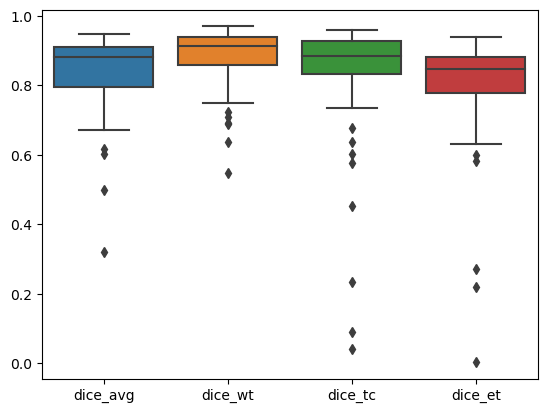

In [86]:
sns.boxplot(metric_df.iloc[:,1:][metric_df.dice_et > 0 ].filter(axis=1,regex="^dice"));

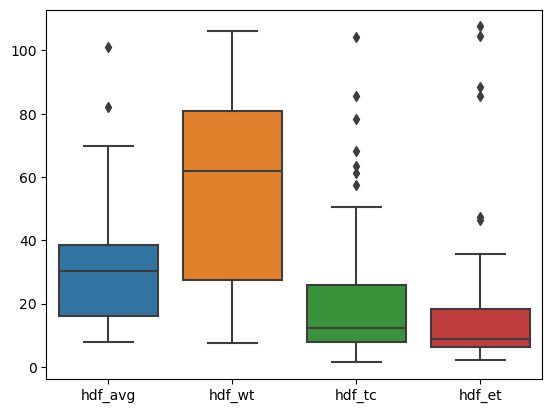

In [87]:
sns.boxplot(metric_df.iloc[:,1:][metric_df.dice_et > 0 ].filter(axis=1,regex="^hdf"));

### Textural and Non Textural Comparison between ground truth and prediction

In [93]:
non_txt_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   case          74 non-null     int64  
 1   wt_ip_volume  74 non-null     float64
 2   wt_ip_center  74 non-null     object 
 3   tc_ip_volume  74 non-null     float64
 4   tc_ip_center  74 non-null     object 
 5   et_ip_volume  74 non-null     float64
 6   et_ip_center  68 non-null     object 
 7   wt_op_volume  74 non-null     float64
 8   wt_op_center  74 non-null     object 
 9   tc_op_volume  74 non-null     float64
 10  tc_op_center  74 non-null     object 
 11  et_op_volume  74 non-null     float64
 12  et_op_center  73 non-null     object 
dtypes: float64(6), int64(1), object(6)
memory usage: 7.6+ KB


### Comparison of Center point


In [137]:
def distance_between_midpoints(p1, p2):
            """Given 2 3D points calculate euclidean distance between them.
            Coordinates in (x,y,z)

            Args:
                p1 (tuple): point 1
                p2 (tuple): point 2

            Returns:
                _type_: distance
            """
            try:
                if np.isnan(p1) or np.isnan(p2):
                    return np.nan
            except Exception:
                pass
            
            return  np.sqrt(p2[0] - p1[0] ** 2 + (p2[1] - p1[1]) ** 2 + (p2[2] - p1[2]) ** 2)

In [ ]:
wt_center_offset = non_txt_features_df.apply(
    lambda row: distance_between_midpoints(row['wt_ip_center'], row['wt_op_center']), axis=1
)

tc_center_offset = non_txt_features_df.apply(
    lambda row: distance_between_midpoints(row['tc_ip_center'], row['tc_op_center']), axis=1
)

et_center_offset = non_txt_features_df.apply(
    lambda row: distance_between_midpoints(row['et_ip_center'], row['et_op_center']), axis=1
)

df = pd.DataFrame({
    "wt" : wt_center_offset,
    "tc" : tc_center_offset,
    "et" : et_center_offset
})

Text(0, 0.5, 'Centerpoint offset (mm)')

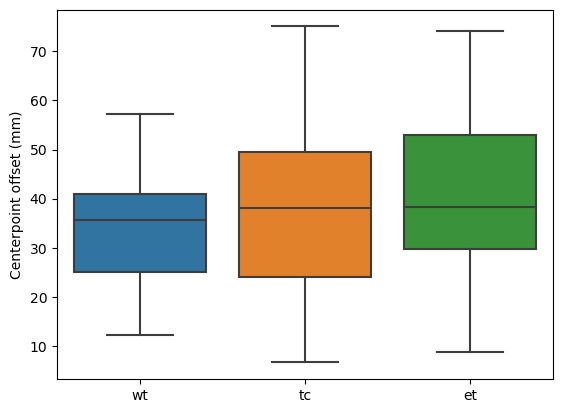

In [143]:
fig = sns.boxplot(df)
fig.set_ylabel("Centerpoint offset (mm)")

In [141]:
df.describe()

,wt,tc,et
count,22.000000,22.000000,20.000000
mean,34.357557,38.310299,40.541025
std,12.635299,17.071492,17.030590
min,12.250243,6.662523,8.803394
25%,25.049824,24.071275,29.698556
50%,35.653347,38.054433,38.383032
75%,40.969910,49.489572,52.894554
max,57.149328,75.036800,74.039412


### Comparison of Difference in Tumor Volume

In [146]:
wt_vol = non_txt_features_df["wt_op_volume"] - non_txt_features_df["wt_ip_volume"]
tc_vol = non_txt_features_df["tc_op_volume"] - non_txt_features_df["tc_ip_volume"]
et_vol = non_txt_features_df["et_op_volume"] - non_txt_features_df["et_ip_volume"]

df = pd.DataFrame({
    'wt' : wt_vol,
    'tc' : tc_vol,
    'et' : et_vol
})


In [147]:
df.describe()

,wt,tc,et
count,74.000000,74.000000,74.000000
mean,-2.811419,-0.544986,-0.474392
std,14.035652,19.512801,6.897106
min,-51.154000,-102.767000,-40.020000
25%,-10.338750,-3.044250,-1.875750
50%,0.148500,-0.244500,0.033000
75%,4.284000,3.318250,2.118000
max,49.662000,50.538000,16.205000


Text(0, 0.5, 'Difference in Volume (ml)')

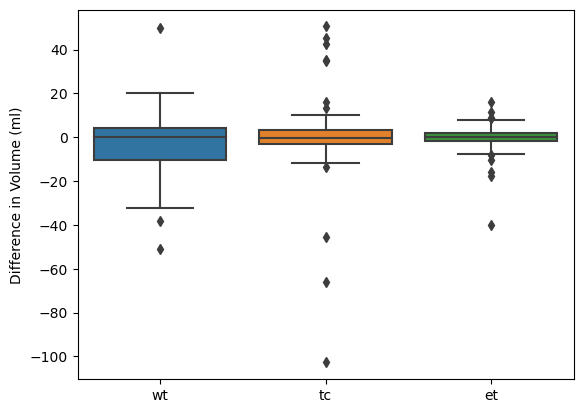

In [153]:
fig = sns.boxplot(df)
fig.set_ylabel("Difference in Volume (ml)")

### Comparison of % difference of textural features.

$$\frac{original-pred}{original}\cdot100$$

Direction vectors used are:
- (1,0,0) : x direction
- (0,0,0) : y direction
- (0,0,1) : z direction
- (1,1,1) : diag direction


In [154]:
txt_features_df.keys()

Index(['case', 'xd_t1_ip_energy', 'xd_t1_ip_homogeneity', 'xd_t1_ip_contrast',
       'xd_t1_ip_entropy', 'xd_t1_ip_correlation', 'xd_t1ce_ip_energy',
       'xd_t1ce_ip_homogeneity', 'xd_t1ce_ip_contrast', 'xd_t1ce_ip_entropy',
       ...
       'dd_t2_op_energy', 'dd_t2_op_homogeneity', 'dd_t2_op_contrast',
       'dd_t2_op_entropy', 'dd_t2_op_correlation', 'dd_flair_op_energy',
       'dd_flair_op_homogeneity', 'dd_flair_op_contrast',
       'dd_flair_op_entropy', 'dd_flair_op_correlation'],
      dtype='object', length=161)

In [171]:
diff_feature = {}
for scan in ['t1','t1ce','t2','flair']:
    for direction in ["xd","yd","zd","dd"]:
        for ft in ["energy","homogeneity","contrast","entropy","correlation"]:
            temp = txt_features_df.filter(regex=f"^{direction}_{scan}_",axis=1)
            diff = np.abs(temp[f"{direction}_{scan}_ip_{ft}"] - temp[f"{direction}_{scan}_op_{ft}"]) / temp[f"{direction}_{scan}_ip_{ft}"] * 100

            diff_feature[f"{direction}_{scan}_{ft}"] = diff





df = pd.DataFrame(diff_feature)       
        

In [ ]:
df.filter(regex="xd_t1_",axis=1)

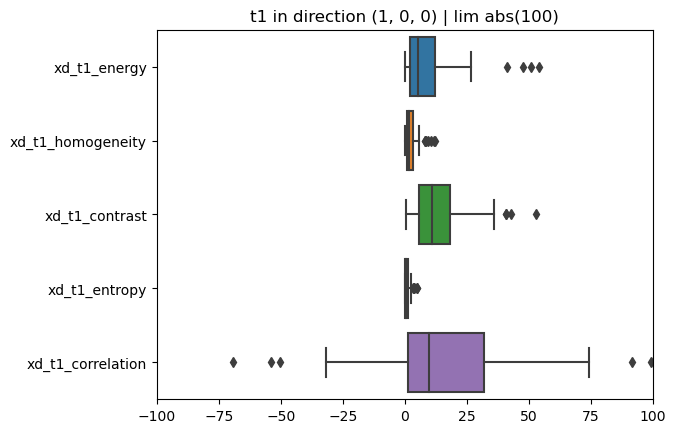

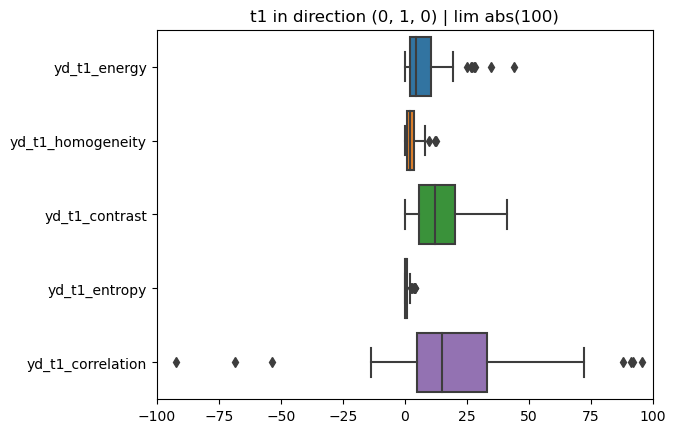

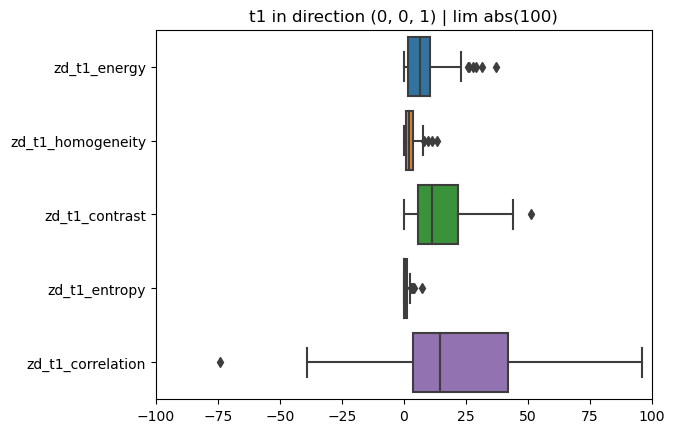

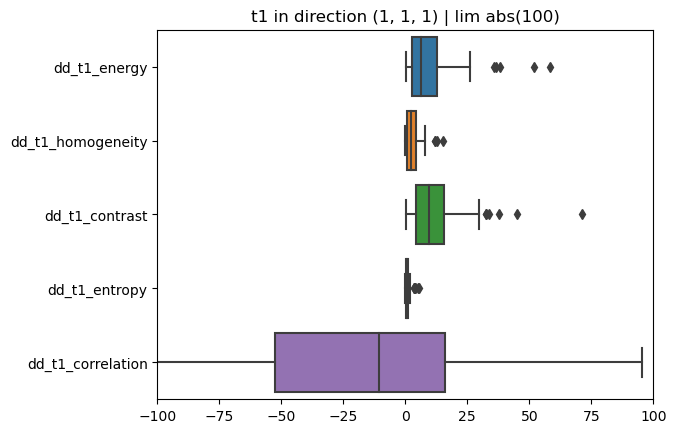

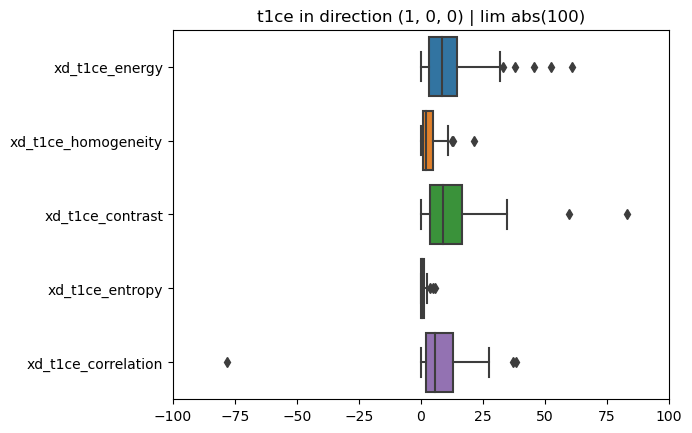

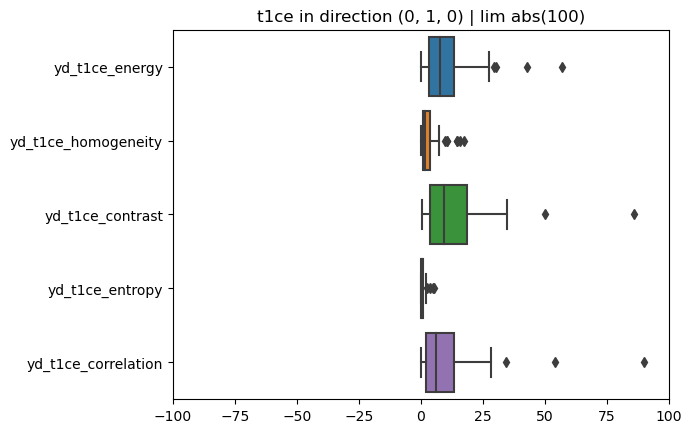

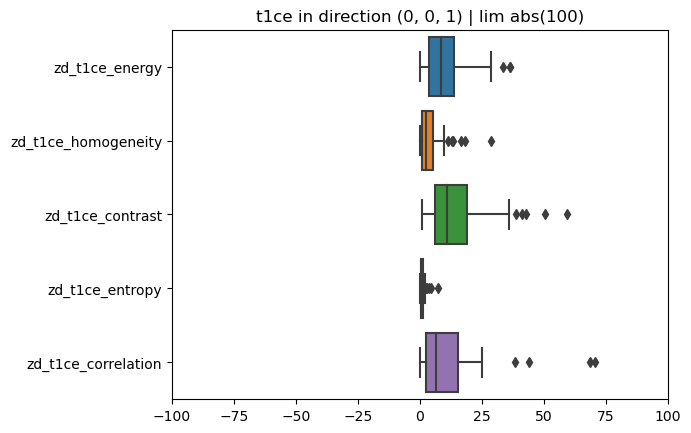

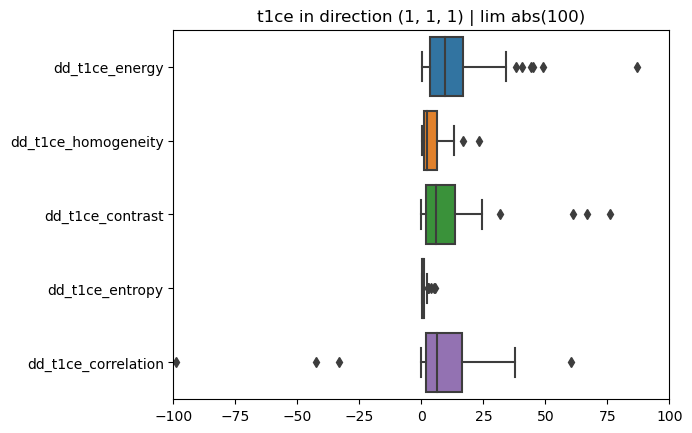

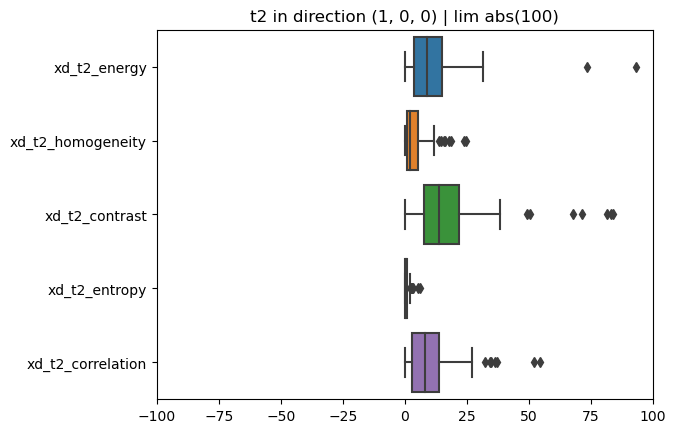

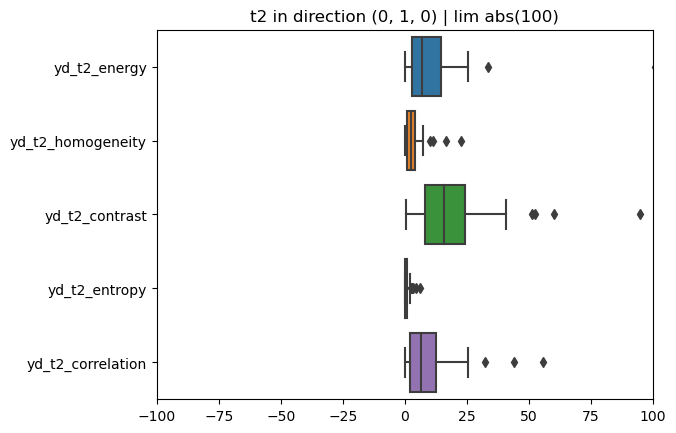

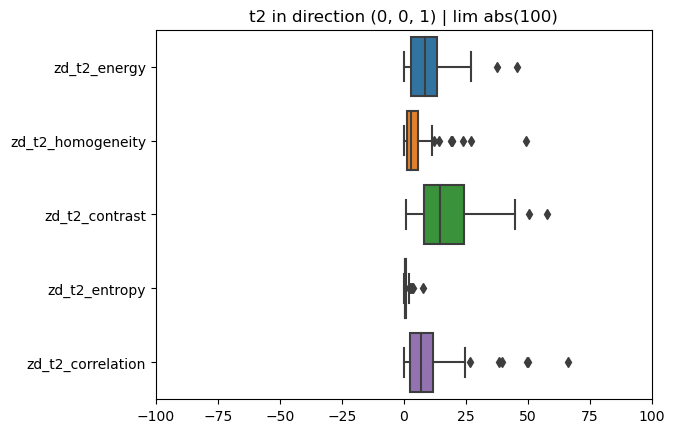

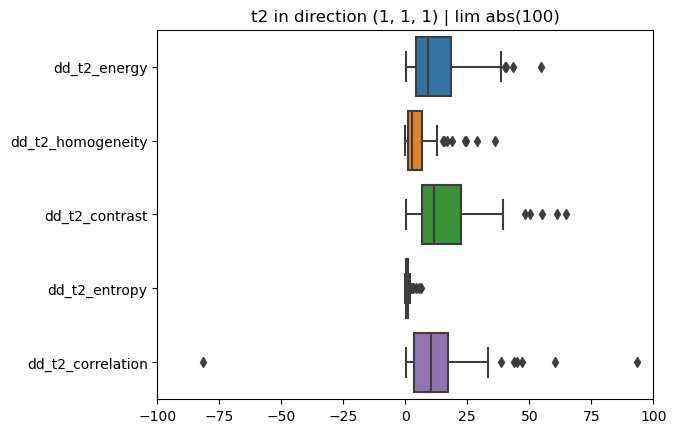

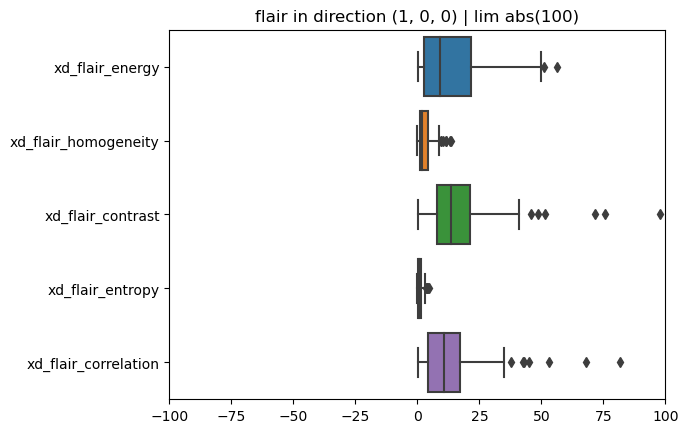

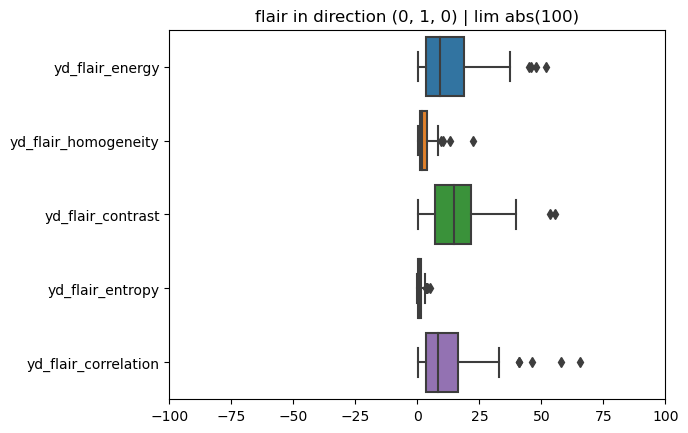

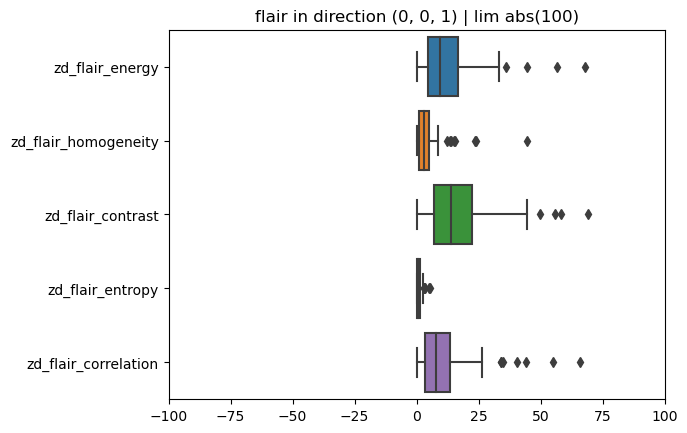

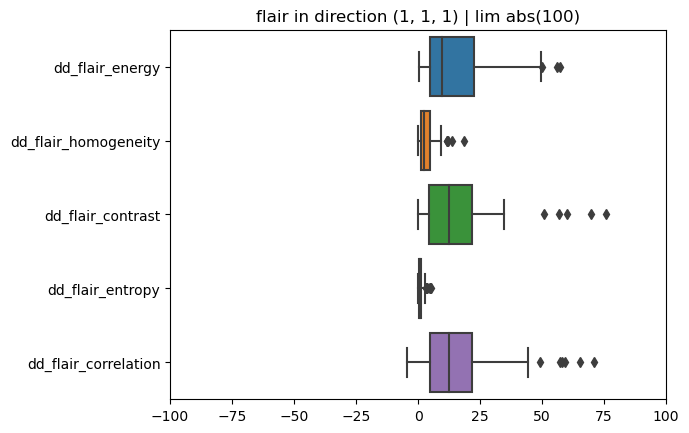

In [199]:
for scan in ['t1','t1ce','t2','flair']:
    for direction, label in [
        ("xd", (1, 0, 0)),
        ("yd", (0, 1, 0)),
        ("zd", (0, 0, 1)),
        ("dd", (1, 1, 1)),
    ]:
        fig = sns.boxplot(df.filter(regex=f"{direction}_{scan}_",axis=1),orient='h')
        fig.set_xlim(-100,100)
        fig.set_title(f"{scan} in direction {label} | lim abs(100)")
        plt.show()

In [198]:
df.describe()

,xd_t1_energy,xd_t1_homogeneity,xd_t1_contrast,xd_t1_entropy,xd_t1_correlation,yd_t1_energy,yd_t1_homogeneity,yd_t1_contrast,yd_t1_entropy,yd_t1_correlation,...,zd_flair_energy,zd_flair_homogeneity,zd_flair_contrast,zd_flair_entropy,zd_flair_correlation,dd_flair_energy,dd_flair_homogeneity,dd_flair_contrast,dd_flair_entropy,dd_flair_correlation
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,...,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,9.274663,2.635732,15.179199,0.921563,-1688.234109,7.986856,2.723346,15.223695,0.866254,83.474837,...,13.006989,4.639768,17.407688,0.972129,11.517963,17.302879,3.549648,15.640858,1.106239,21.253855
std,11.548161,2.757238,16.243973,1.068331,14277.636984,8.923492,2.709738,16.191231,0.967003,414.459056,...,12.471899,6.718073,14.550403,1.056250,12.835114,23.367502,3.441952,15.754657,1.241729,31.920086
min,0.139768,0.033143,0.397429,0.005270,-122835.753344,0.154084,0.023395,0.077819,0.057820,-532.214791,...,0.306740,0.060776,0.264907,0.005004,0.068958,0.249600,0.035335,0.039129,0.016122,-4.649175
25%,1.948097,0.722068,5.841414,0.209432,1.273724,1.993584,0.726593,5.837903,0.243147,4.859767,...,4.730825,1.009525,7.151250,0.246992,3.499749,4.735463,1.276433,4.387616,0.244497,5.000459
50%,5.451979,1.827583,11.056991,0.521452,9.867011,4.417287,2.014553,12.400031,0.526519,15.062176,...,9.604223,2.868259,13.812575,0.704054,7.691130,9.687445,2.407608,12.310059,0.729130,12.470902
75%,12.176323,3.322725,18.309044,1.258325,32.123175,10.543227,3.763703,20.324635,1.101799,33.088282,...,16.763047,5.071209,22.223528,1.218645,13.499396,22.671143,4.829358,21.815102,1.305781,21.849729
max,54.219640,12.036132,117.311467,4.980206,173.387226,43.921945,12.591509,123.515397,4.318079,3208.190669,...,67.726967,44.514553,69.037888,5.293303,65.919572,173.533750,18.340842,75.726924,5.009633,231.810942


### Visualising Worse Case Scenarios

In [68]:
def plot_grid(result):
    fig, ax = plt.subplots(9,6,figsize=(20,30),sharex=True,sharey=True)
    # Set Column Names
    ax[0,0].set_title("WT GT");
    ax[0,1].set_title("WT Pred");
    ax[0,2].set_title("TC GT");
    ax[0,3].set_title("TC Pred");
    ax[0,4].set_title("ET GT");
    ax[0,5].set_title("ET Pred");

    slices = [37, 47, 57, 67, 77, 87, 97, 107, 117]

    result['input']['seg'] = result['input']['seg'].to('cpu')
    result['pred'] = result['pred'].to('cpu') 


    for row_id,slice in enumerate(slices):
        ax[row_id,0].imshow(result['input']['seg'][0][...,slice],cmap='gray')
        ax[row_id,0].set_ylabel(f"Slice: {slice+1}")

        ax[row_id,1].imshow(result['pred'][0][0][...,slice],cmap='gray')


        ax[row_id,2].imshow(result['input']['seg'][1][...,slice],cmap='gray')
        ax[row_id,3].imshow(result['pred'][0][1][...,slice],cmap='gray')

        ax[row_id,4].imshow(result['input']['seg'][2][...,slice],cmap='gray')
        ax[row_id,5].imshow(result['pred'][0][2][...,slice],cmap='gray')


Min Dice Avg and TC

Min Case 361

{'case': [361], 'dice_avg': [0.3196135461330414], 'dice_wt': [0.9138199090957642], 'dice_tc': [0.04199955239892006], 'dice_et': [0.003021148033440113], 'hdf_avg': [56.99939493230739], 'hdf_wt': [103.38762014864255], 'hdf_tc': [32.01562118716424], 'hdf_et': [35.59494346111537]}


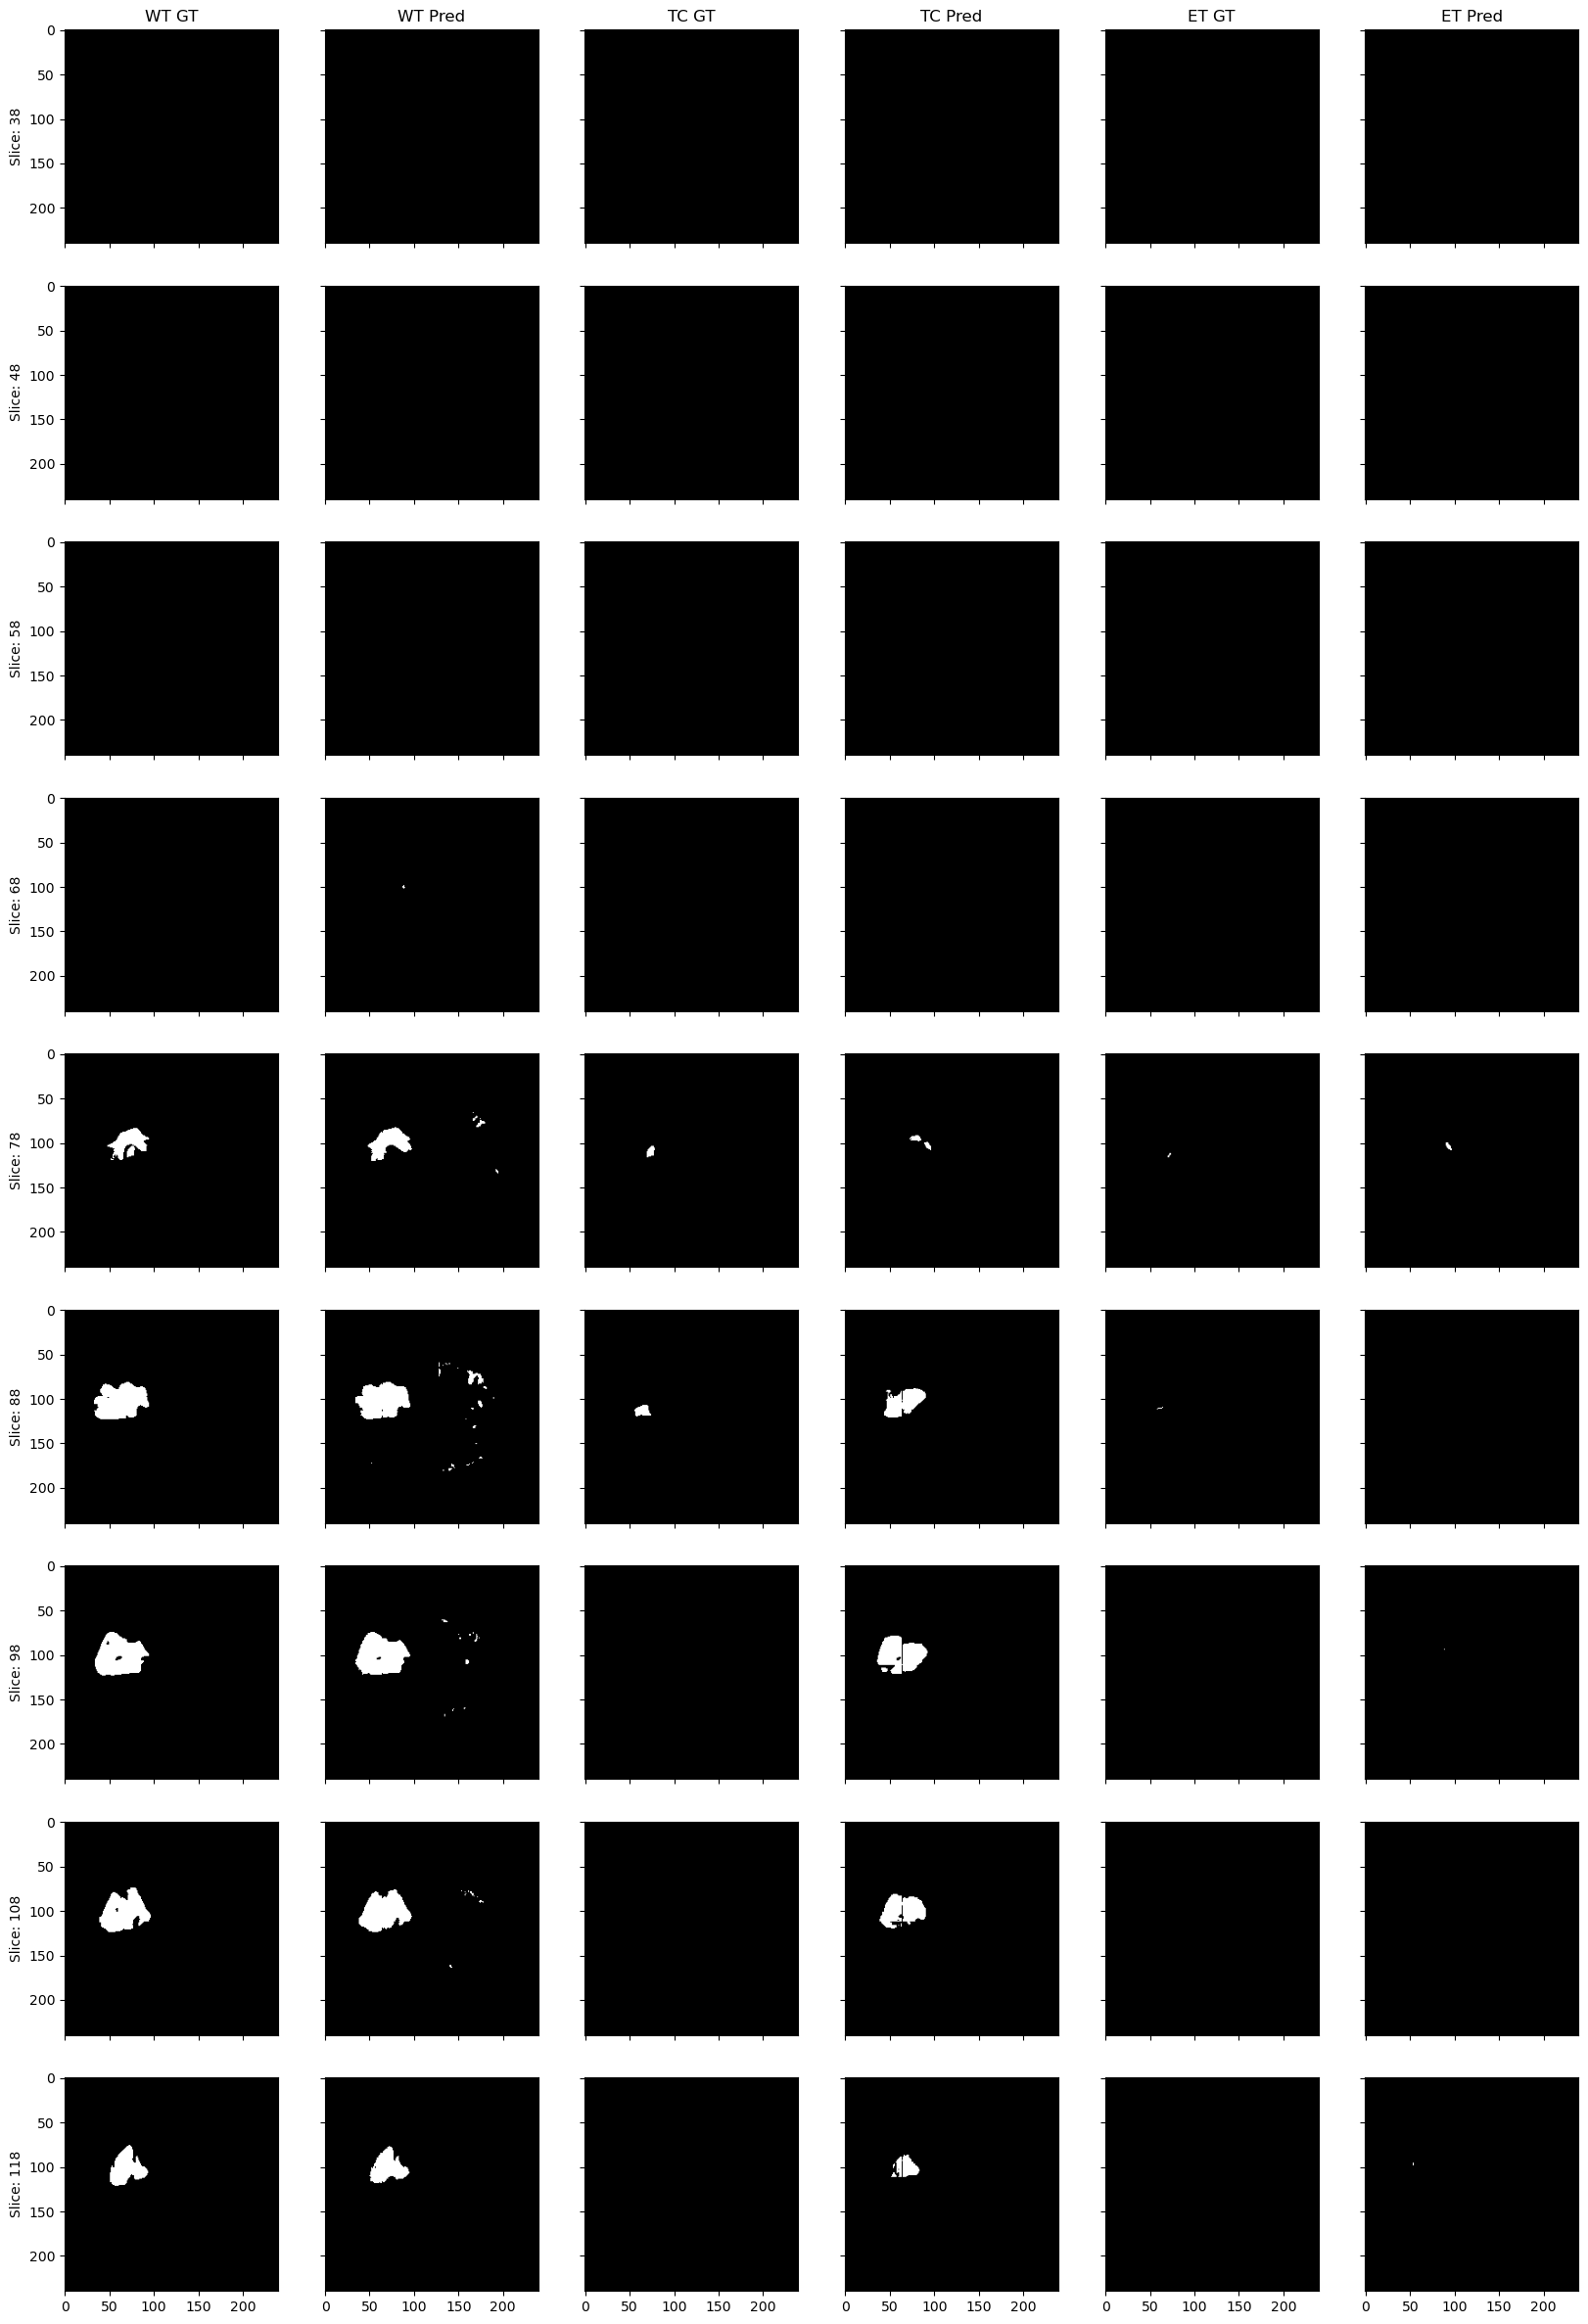

In [72]:
result = evaluate_model(model, 361)
print(result['metrics'])
plot_grid(result)

MIN DICE WT

Case 99

{'case': [99], 'dice_avg': [0.7556002140045166], 'dice_wt': [0.5464361906051636], 'dice_tc': [0.8299791812896729], 'dice_et': [0.8903853297233582], 'hdf_avg': [29.33496566901739], 'hdf_wt': [60.40695324215582], 'hdf_tc': [15.556349186104045], 'hdf_et': [12.041594578792296]}


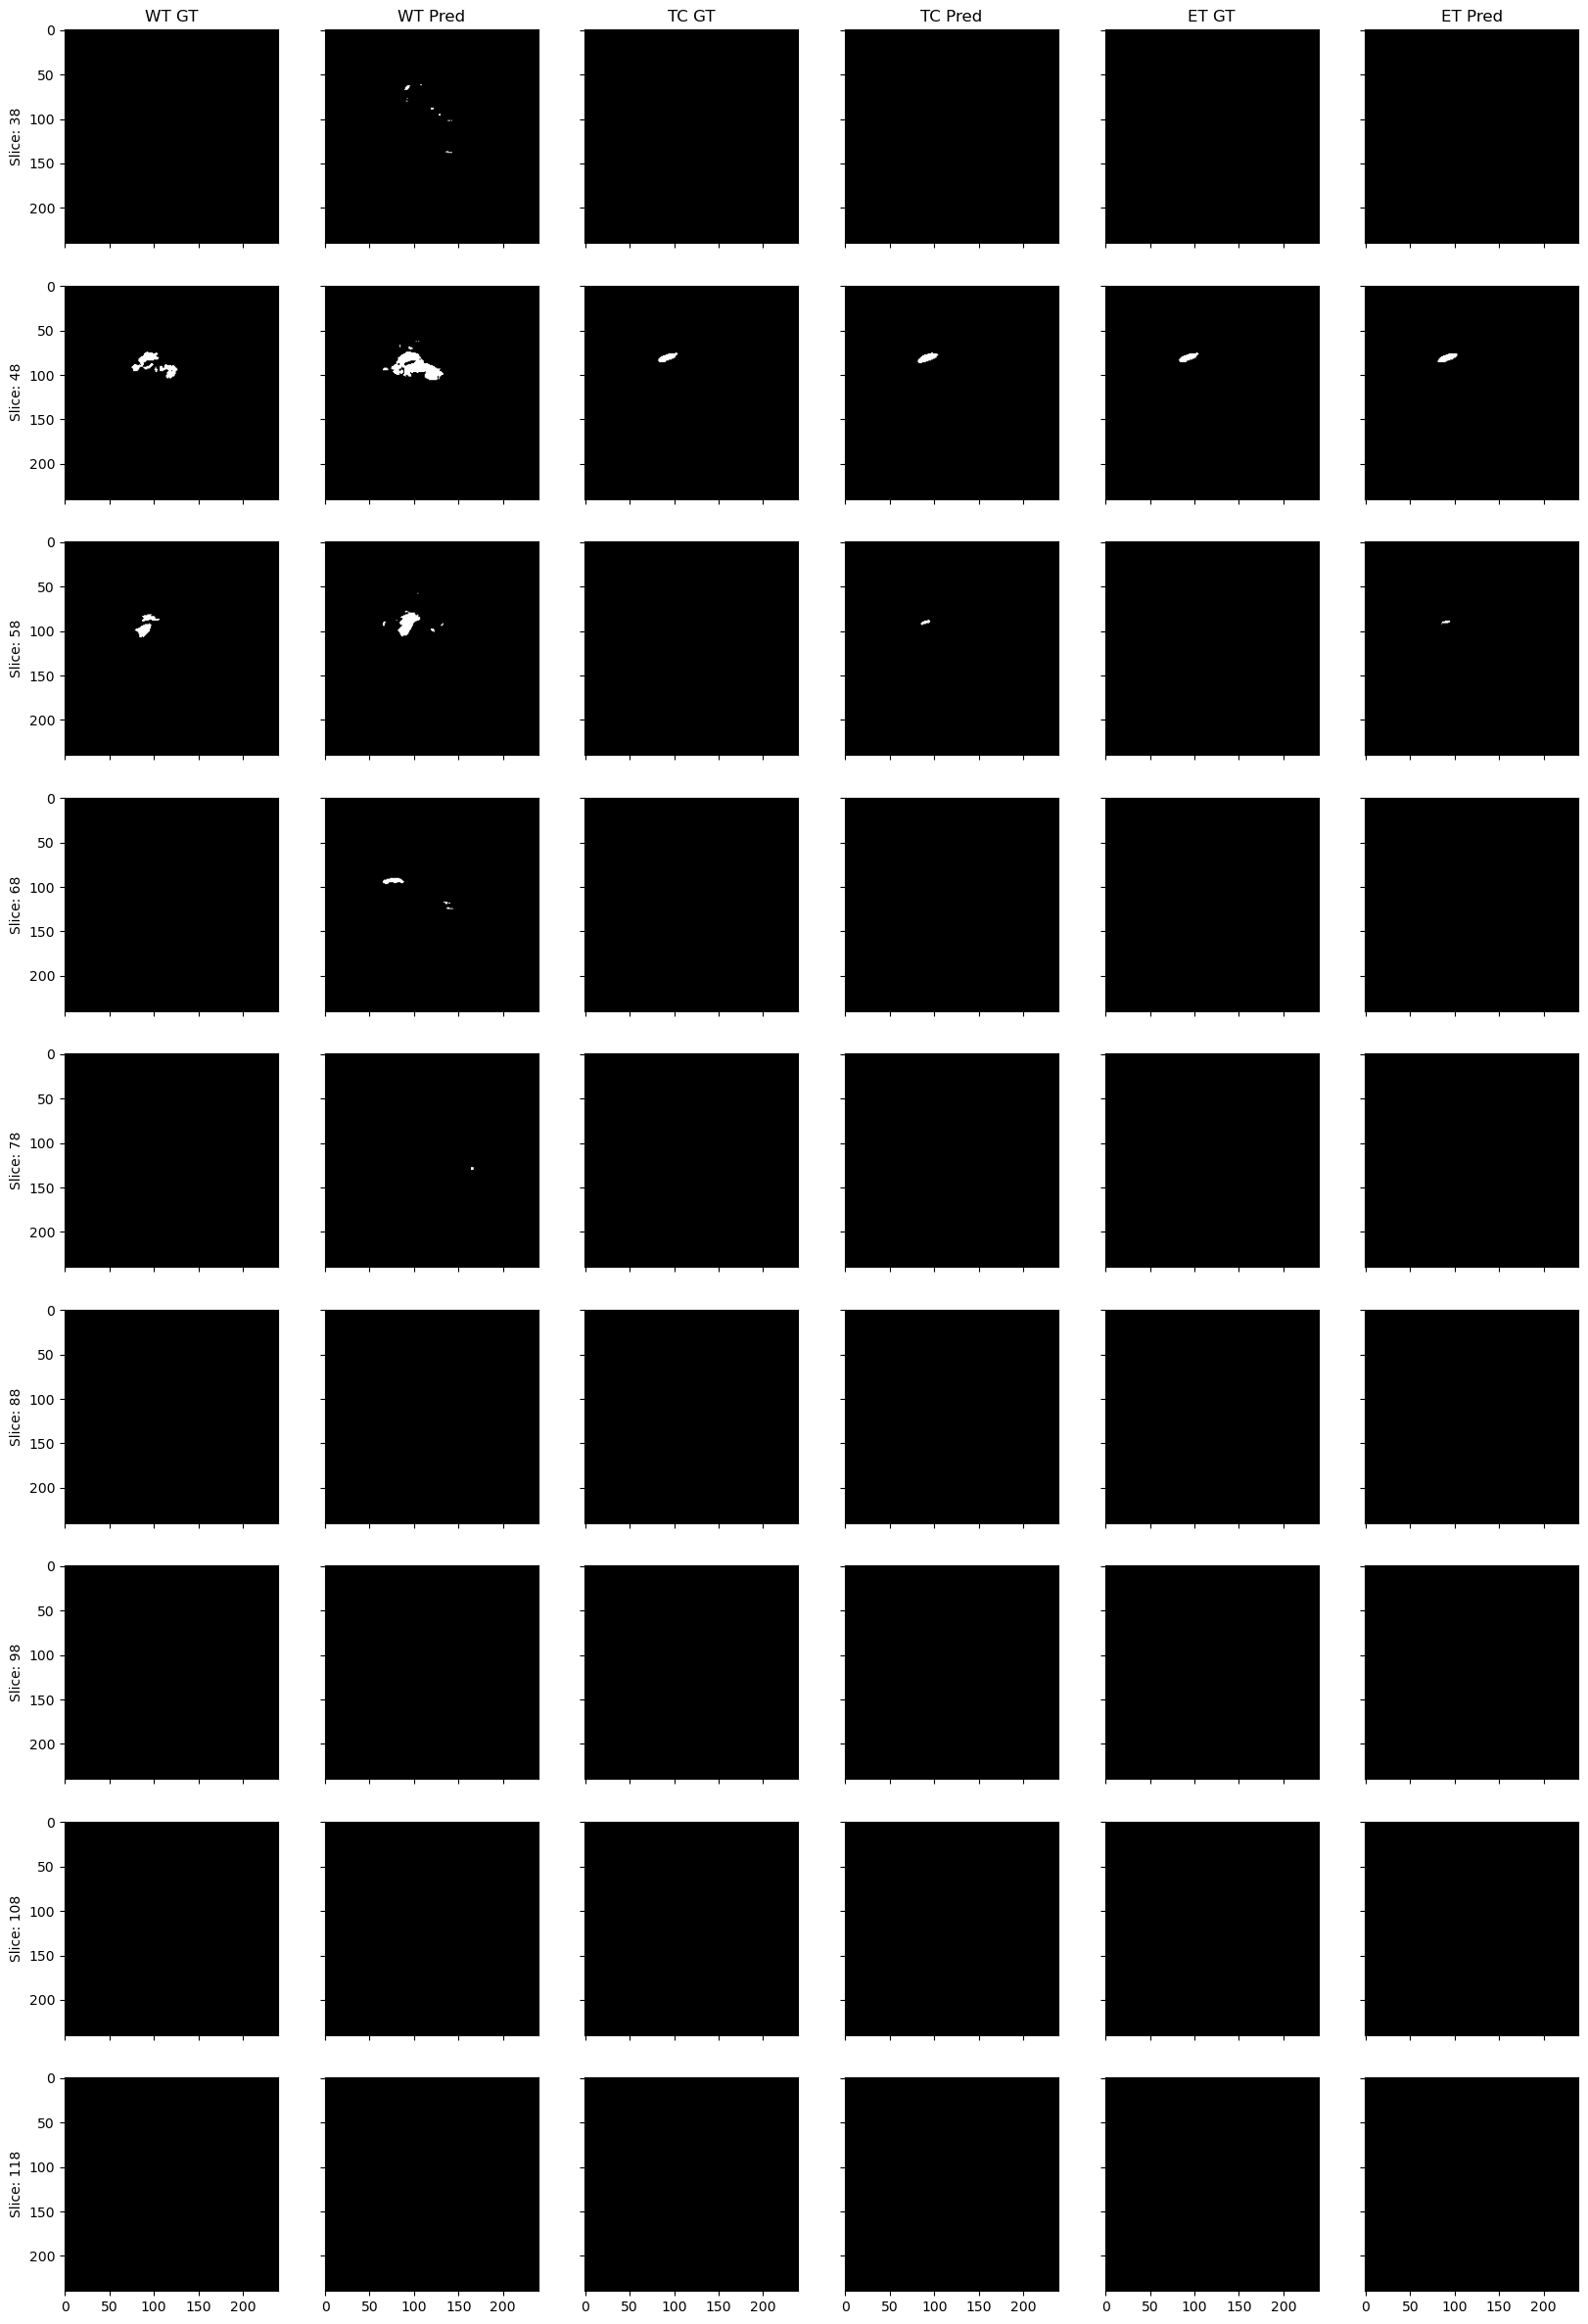

In [73]:
result = evaluate_model(model, 99)
print(result['metrics'])
plot_grid(result)

MIN DICE ET

Case 297

c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\monai\metrics\hausdorff_distance.py:168: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\monai\metrics\hausdorff_distance.py:170: UserWarning: the prediction of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


{'case': [297], 'dice_avg': [0.5975097417831421], 'dice_wt': [0.5704813003540039], 'dice_tc': [0.6245381236076355], 'dice_et': [0.0], 'hdf_avg': [59.889268438068825], 'hdf_wt': [77.37570678190927], 'hdf_tc': [42.40283009422838], 'hdf_et': [0.0]}


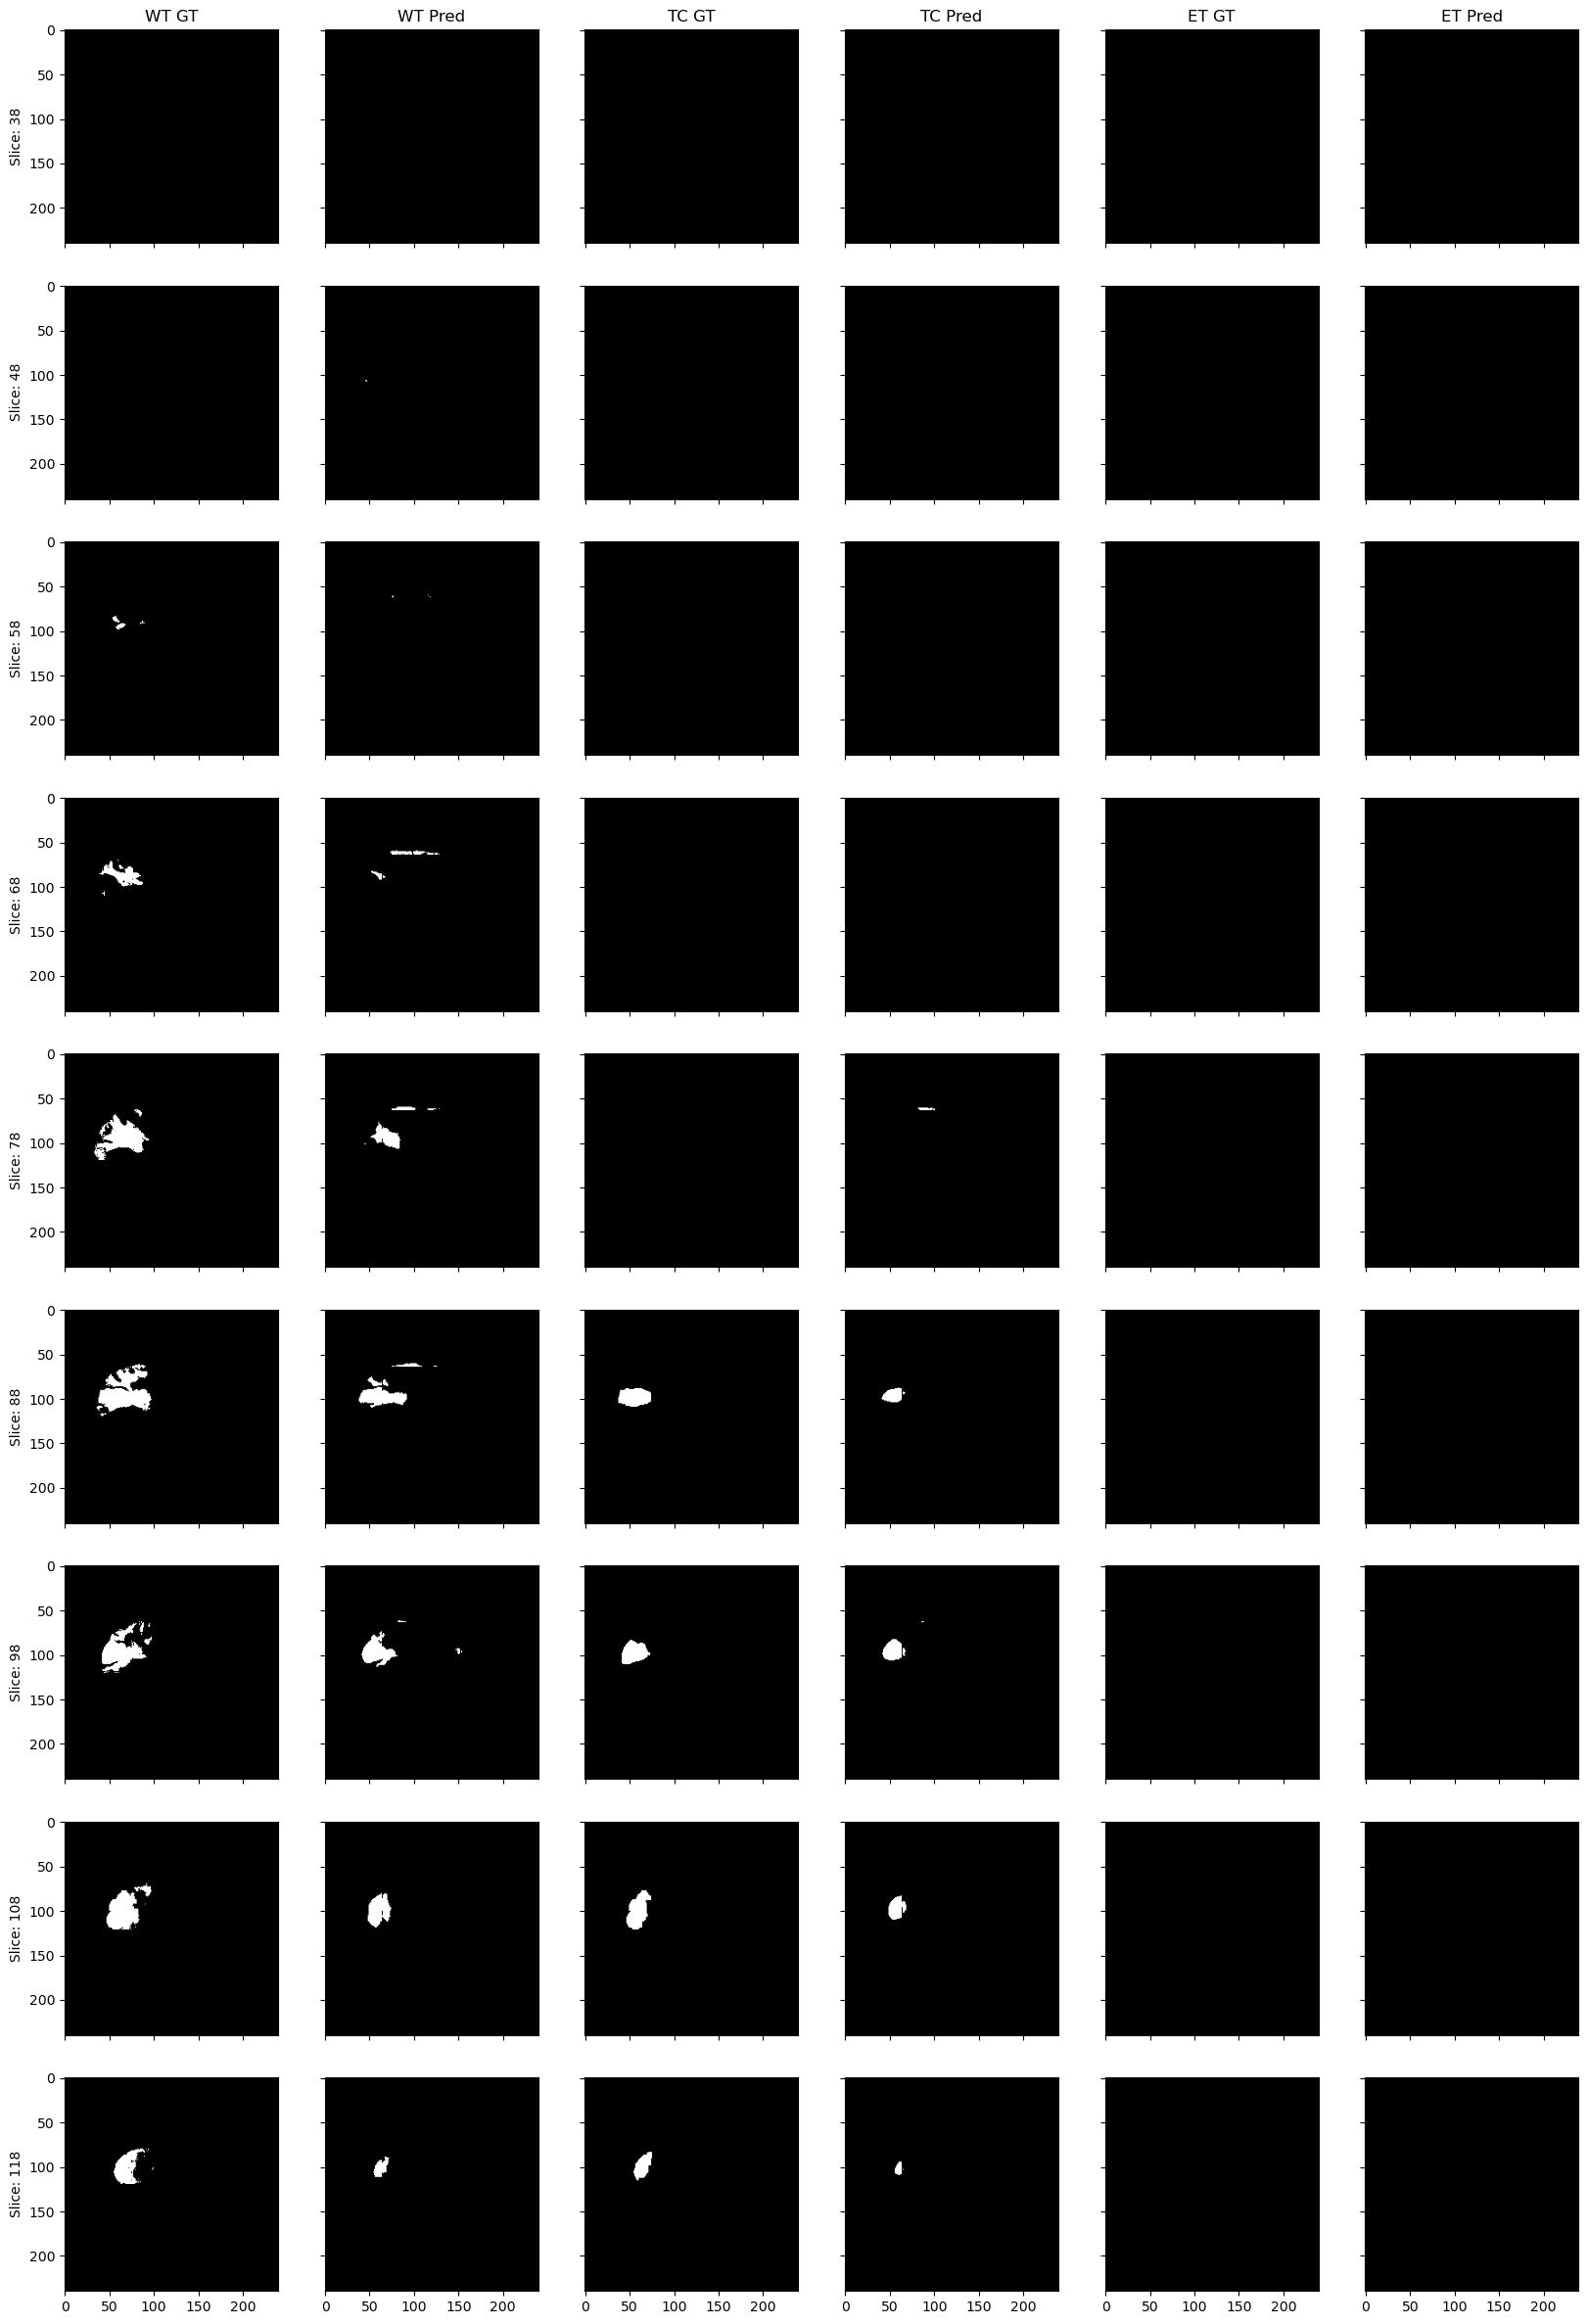

In [76]:
result = evaluate_model(model, 297)
print(result['metrics'])
plot_grid(result)

MIN HDF Average and ET is inf due to ET

MIN HDF at WT Case 356

{'case': [356], 'dice_avg': [0.8890253901481628], 'dice_wt': [0.8527430295944214], 'dice_tc': [0.9349879026412964], 'dice_et': [0.8793451189994812], 'hdf_avg': [40.2312370000619], 'hdf_wt': [106.18380290797651], 'hdf_tc': [8.18535277187245], 'hdf_et': [6.324555320336759]}


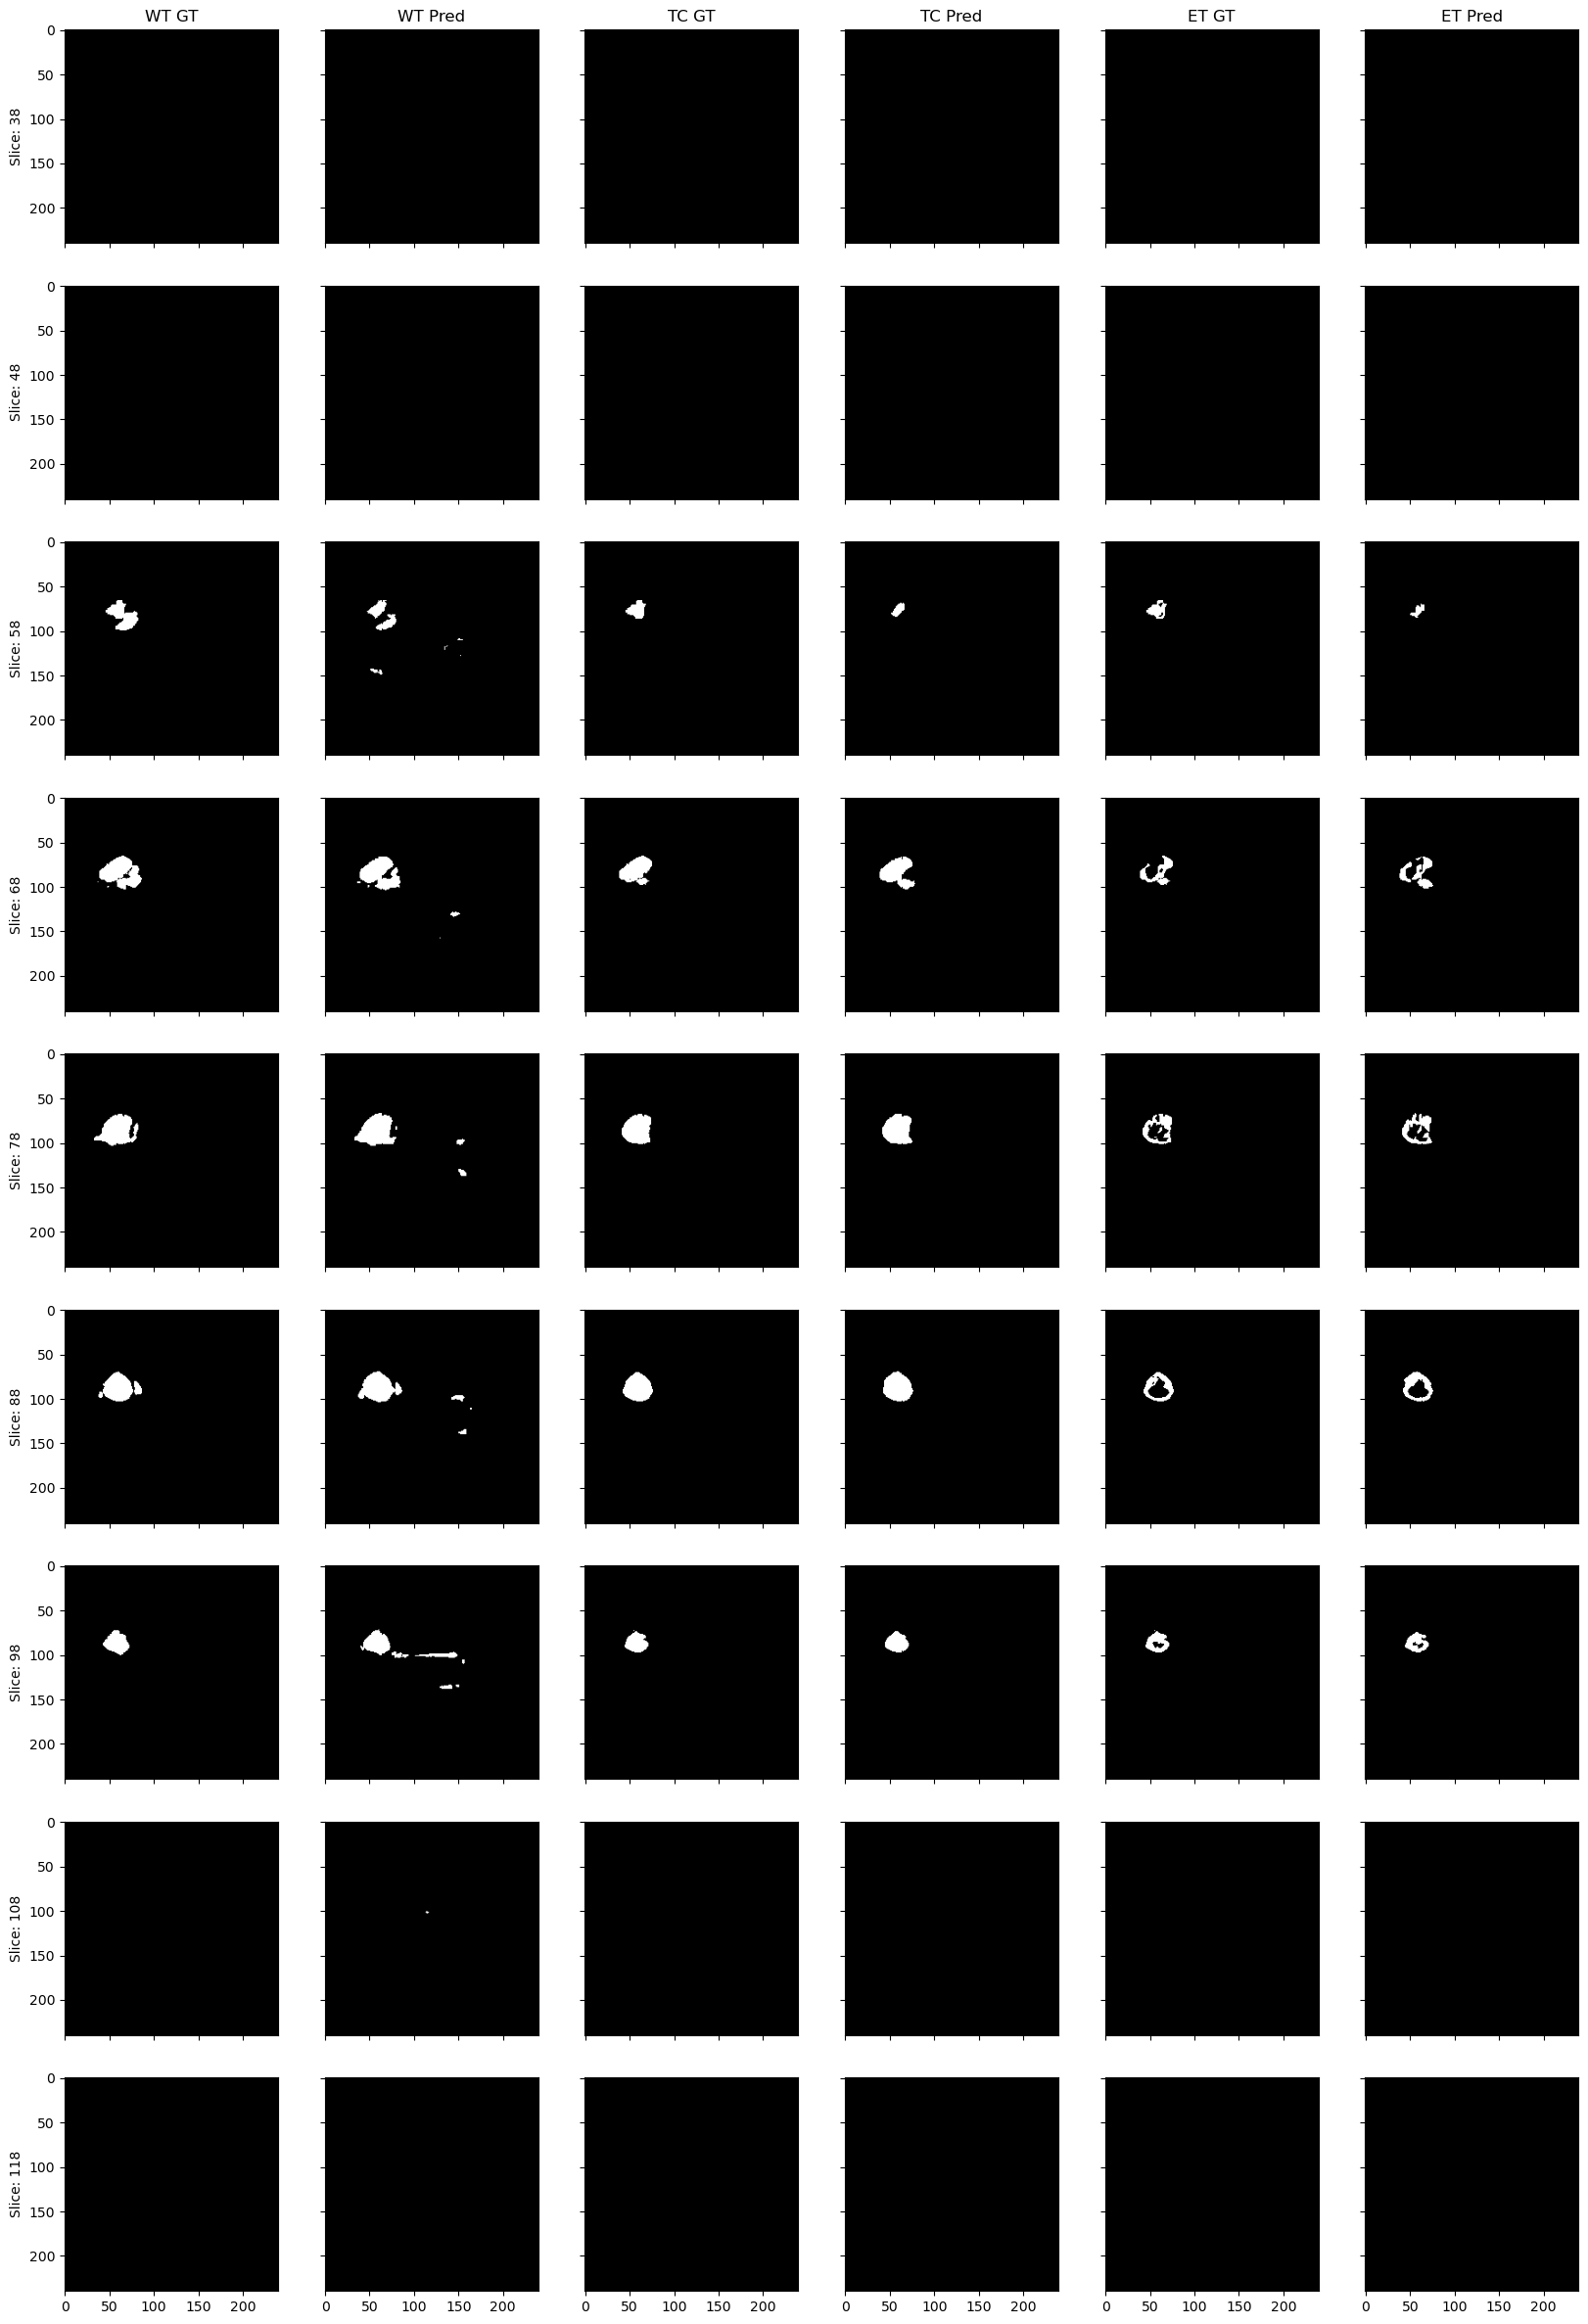

In [77]:
result = evaluate_model(model, 356)
print(result['metrics'])
plot_grid(result)

MIN HDF TC Case 320

{'case': [320], 'dice_avg': [0.7961035370826721], 'dice_wt': [0.7617208957672119], 'dice_tc': [0.8079974055290222], 'dice_et': [0.818592369556427], 'hdf_avg': [101.01036913224895], 'hdf_wt': [94.39279633531363], 'hdf_tc': [104.20172743289815], 'hdf_et': [104.43658362853508]}


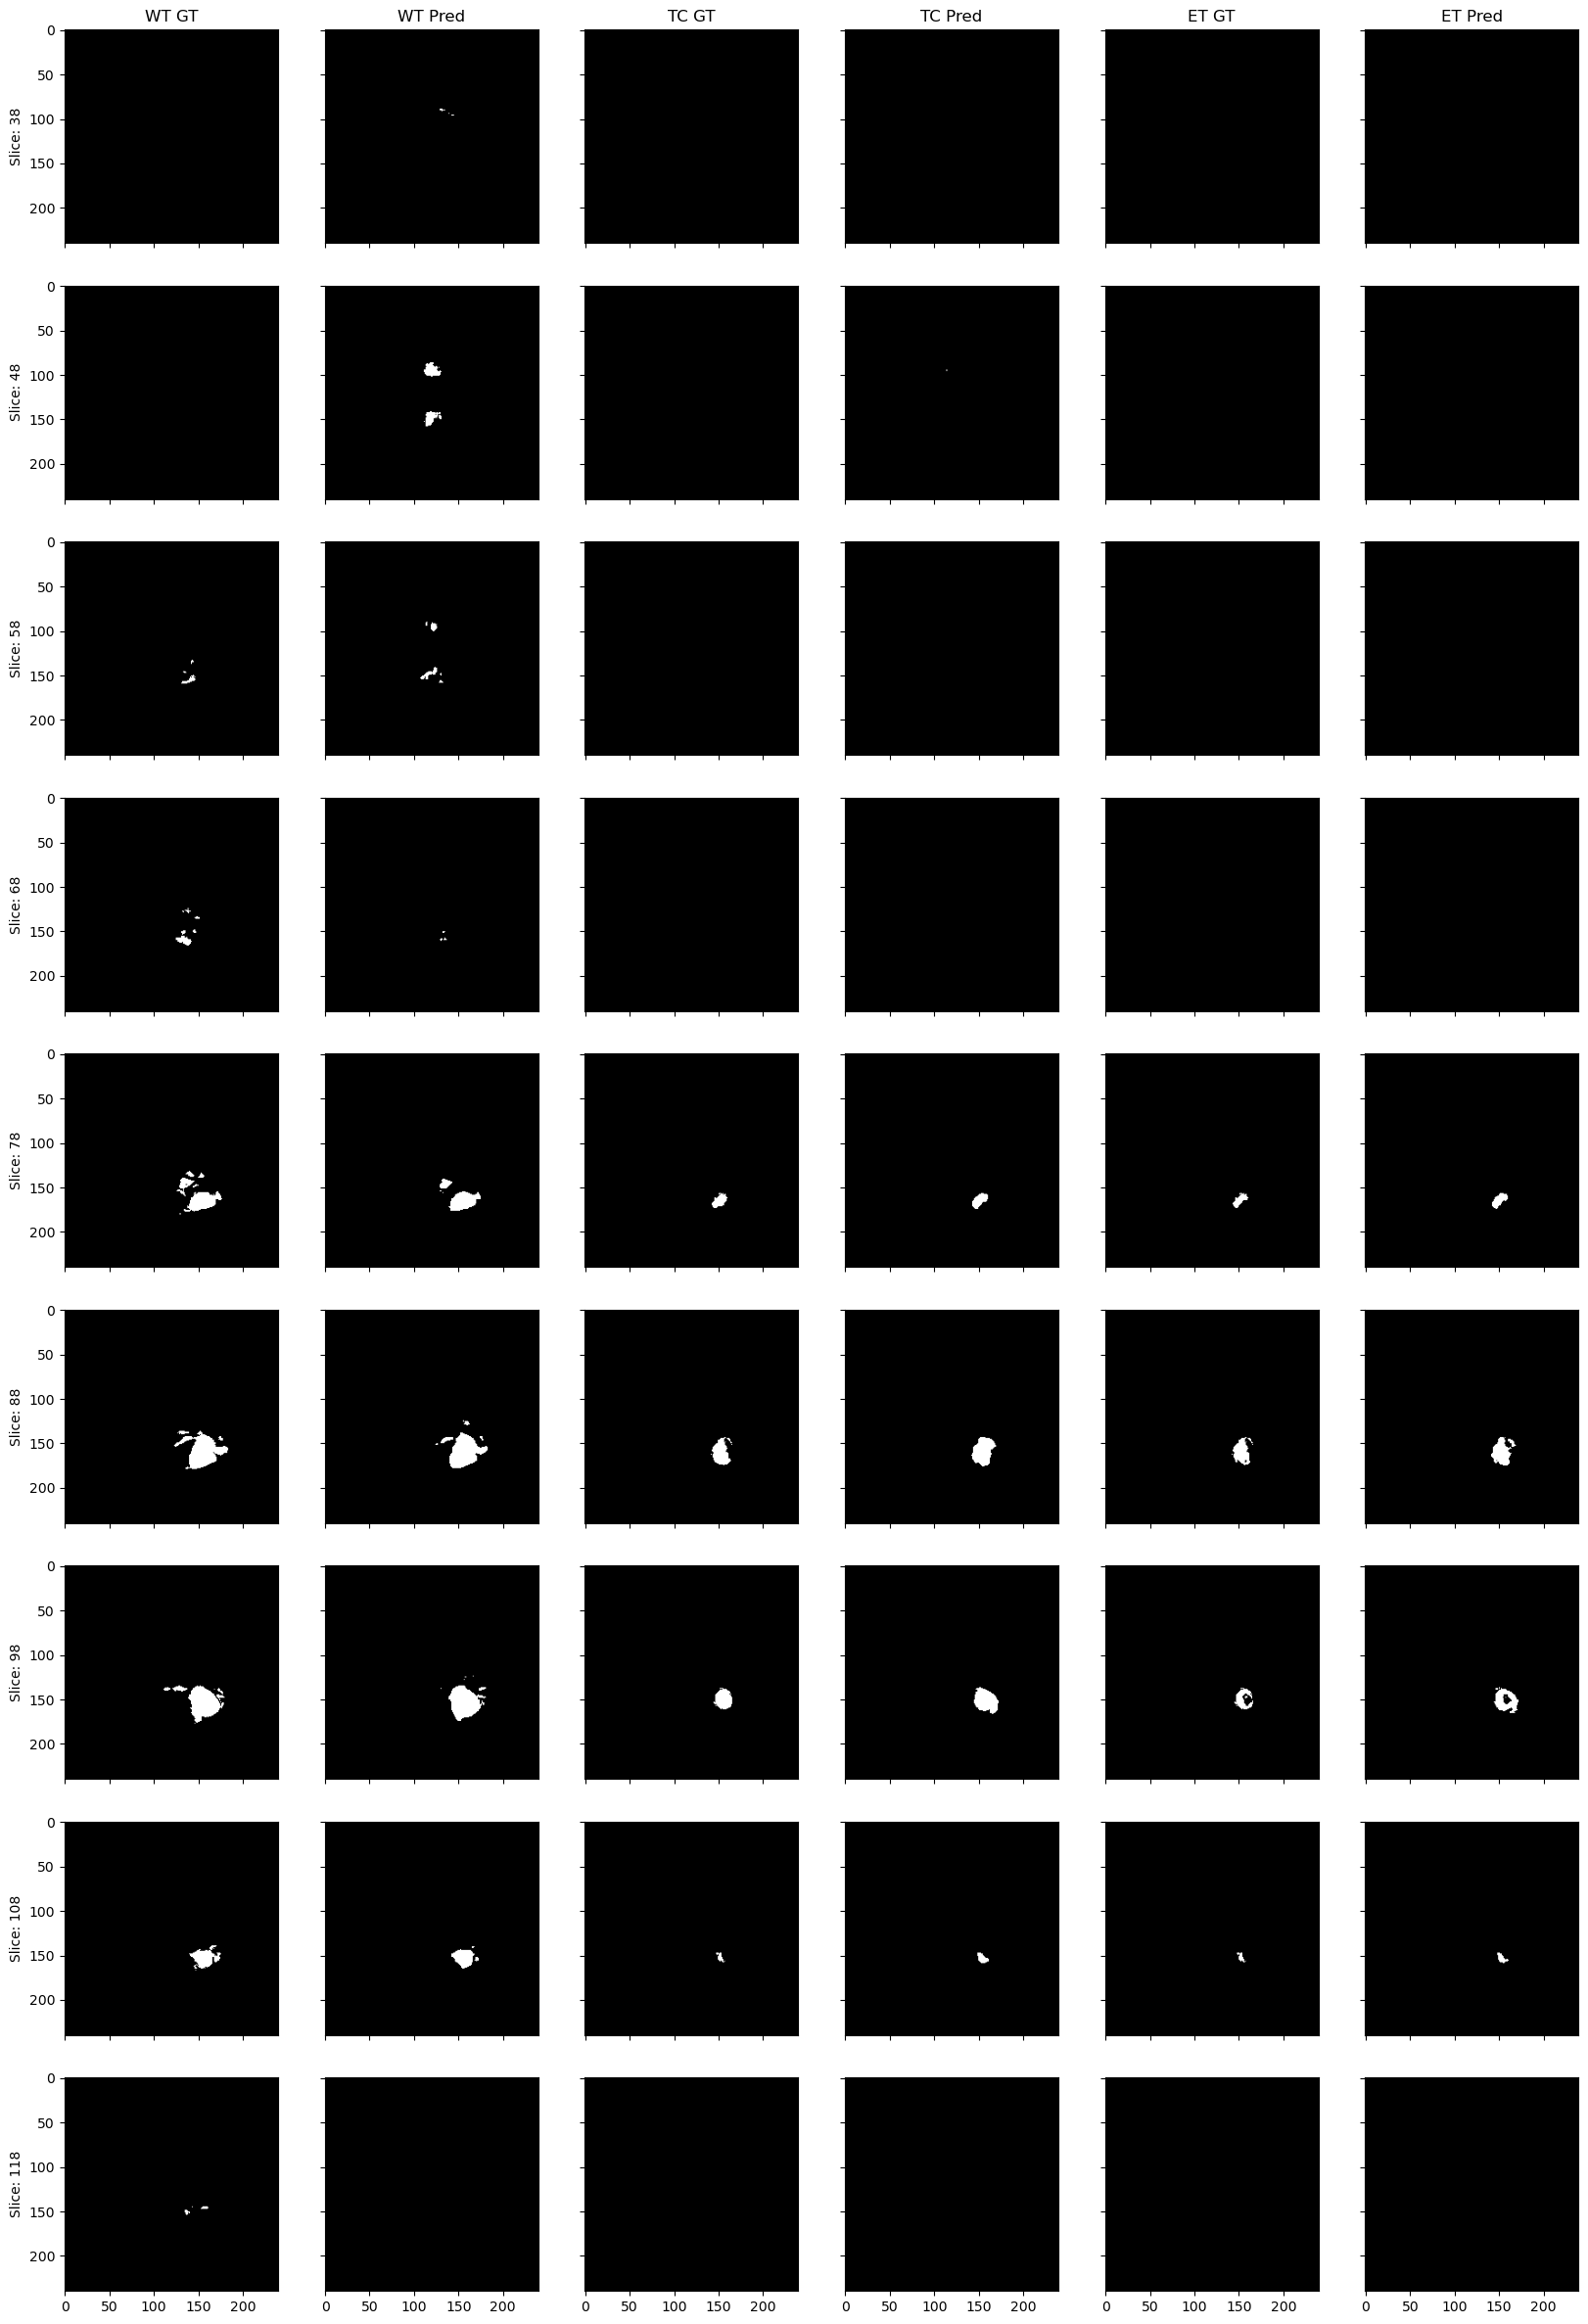

In [78]:
result = evaluate_model(model, 320)
print(result['metrics'])
plot_grid(result)